In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid
import gcm_filters

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in data for 1/2 degree parameterized runs:


In [6]:
##Unparameterized run
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
fs = xr.open_dataset('static.nc', decode_times=False)
av =xr.open_dataset('averages_00031502.nc',decode_times=False)
os = xr.open_dataset('ocean.stats.nc', decode_times=False)

%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS02_COEF07/
test1 = xr.open_dataset('averages_00031502.nc', decode_times=False)  
os1 = xr.open_dataset('ocean.stats.nc', decode_times=False)

%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS025_COEF1/
test2 = xr.open_dataset('averages_00031502.nc', decode_times=False)  
os2 = xr.open_dataset('ocean.stats.nc', decode_times=False)

%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/Jansen_KS025_CONST1/
test3 = xr.open_dataset('averages_00031502.nc', decode_times=False)  
os3 = xr.open_dataset('ocean.stats.nc', decode_times=False)

# #Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default/
# av_05_GMBS = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# os_05_GMBS = xr.open_dataset('ocean.stats.nc', decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
# av_05_BS = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# os_05_BS = xr.open_dataset('ocean.stats.nc', decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.5
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
# av_05_GM = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# os_05_GM = xr.open_dataset('ocean.stats.nc', decode_times=False)



%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/



/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS02_COEF07
/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS025_COEF1
/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/Jansen_KS025_CONST1
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


## Computing the truth case (1/32 degree):

In [20]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs_HR = xr.open_dataset('static.nc', decode_times=False)
os_HR = xr.open_dataset('sub20/ocean.stats.nc', decode_times=False)
av_HR = xr.open_dataset('averages_00002702.nc', decode_times=False)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


#Read in various grid variables from the static file and forcing:
lon=fs_HR['geolon']; lat=fs_HR['geolat']
depth = fs_HR['depth_ocean']
area_t=fs_HR['area_t']

xh = fs_HR.xh
yh = fs_HR.yh

interface_ref=os_HR['H0'].mean('Time'); interface_ref=interface_ref[:-1]

Layer = (os_HR['Layer']);
drho=xr.zeros_like(interface_ref)
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(interface_ref); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.


h = (av_HR['h'][:,:,:,:])
correction = (interface_ref-depth); #if >0 this means h_ref is deeper than topography, we need correction!
correction = correction.where(correction>0.0).fillna(0) #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = xr.zeros_like(h)
for t in range (0,20):
    for i in range(0,len(Layer)):
        interface[t,i,:,:]=h[t,i:,:,:].sum(axis=0)-depth
        #interface is negative down, interface_ref_mat is positive down
    print(t)
interface_ref_HIC = interface_ref- correction
interface_ref_HIC=interface_ref_HIC.rename({'Interface': 'zl'}); 
drho=drho.rename({'Interface': 'zl'})
interface_ref_HIC.coords['zl'] = h['zl']; drho.coords['zl'] = h['zl']

scale=16

eta = (interface+interface_ref_HIC)
eta_coarse = eta.coarsen(xh=scale,yh=scale, boundary="exact").mean()
area_coarse = area_t.coarsen(xh=scale,yh=scale,boundary="exact").mean()

eta2=eta_coarse**2.
APE_net=(0.5*10*drho*eta2*area_coarse*scale**2).sum('zl')
#/(1022.6*depth)).sum('zl')  #to have units of J don't divide by 1022.6*depth, do multiply by area_t

APE_average_HR = APE_net.mean(axis=0)
print(np.nansum(APE_average_HR),np.nansum(os_HR.APE[-1,1:]))

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
<xarray.DataArray 'H0' (Interface: 15)>
array([-2.23290804e-04,  2.49712825e+01,  7.50754467e+01,  1.75029085e+02,
        2.99815575e+02,  4.49933272e+02,  6.24646187e+02,  8.24913043e+02,
        1.04954125e+03,  1.30001166e+03,  1.59954294e+03,  1.94972088e+03,
        2.35011274e+03,  2.84985560e+03,  3.40045234e+03])
Coordinates:
  * Interface  (Interface) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
9.180149433529195e+19 9.541499154352313e+19


## For the other cases:

In [40]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
area_t=fs['area_t']

xh = fs.xh
yh = fs.yh

interface_ref=os3['H0'].mean('Time'); interface_ref=interface_ref[:-1]
Layer = (os3['Layer']);
drho=xr.zeros_like(interface_ref)
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)


In [41]:
h = (test2['h'][:,:,:,:])#.fillna(0.)
correction = (interface_ref-depth); #if >0 this means h_ref is deeper than topography, we need correction!
correction = correction.where(correction>0.0).fillna(0) #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = xr.zeros_like(h)
for t in range (0,100):
    for i in range(0,len(Layer)):
        interface[t,i,:,:]=h[t,i:,:,:].sum(axis=0)-depth
        #interface is negative down, interface_ref_mat is positive down
    #print(t)
interface_ref_HIC = interface_ref- correction
interface_ref_HIC=interface_ref_HIC.rename({'Interface': 'zl'}); 
drho=drho.rename({'Interface': 'zl'})
interface_ref_HIC.coords['zl'] = h['zl']; drho.coords['zl'] = h['zl']


In [42]:

eta = (interface+interface_ref_HIC)

eta2=eta**2.
APE_net=(0.5*10*drho*eta2*area_t).sum('zl')
#/(1022.6*depth)).sum('zl')  #to have units of J don't divide by 1022.6*depth, do multiply by area_t
APE_average = APE_net.mean(axis=0)
print(np.nansum(APE_average),np.nansum(os2.APE[-1,1:]))

4.222031024547758e+19 4.392338429988871e+19


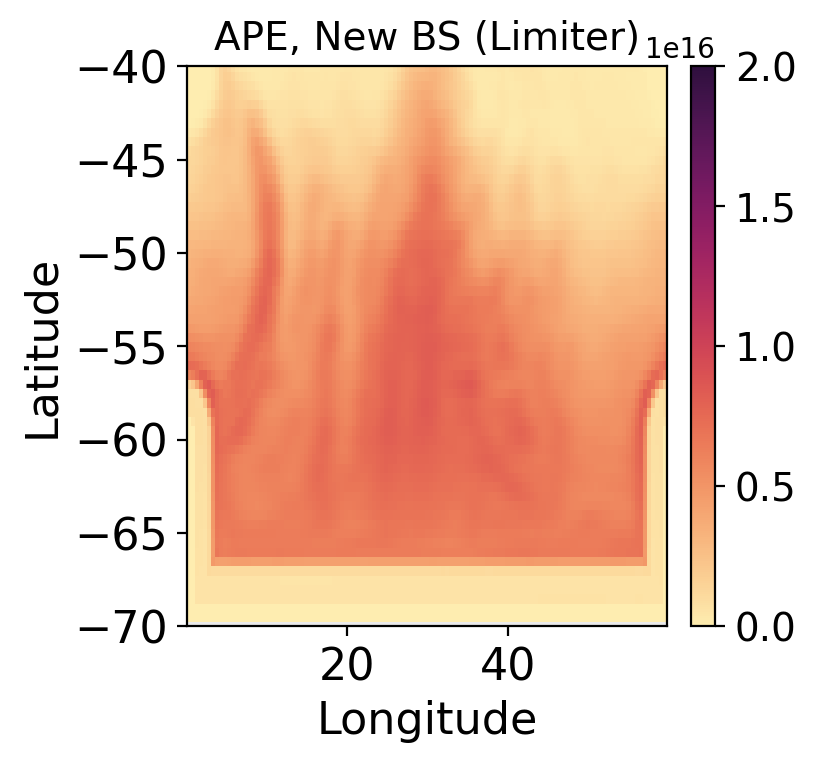

In [43]:
fig = plt.figure(figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('APE, New BS (Limiter)',fontsize=14)

ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=11)



plotted =ax1.pcolor(APE_average.xh,APE_average.yh,(APE_average),cmap=cmocean.cm.matter,vmin=0,vmax=20e15)
#ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax1.set_ylim([-70,-40])

#
plt.show()

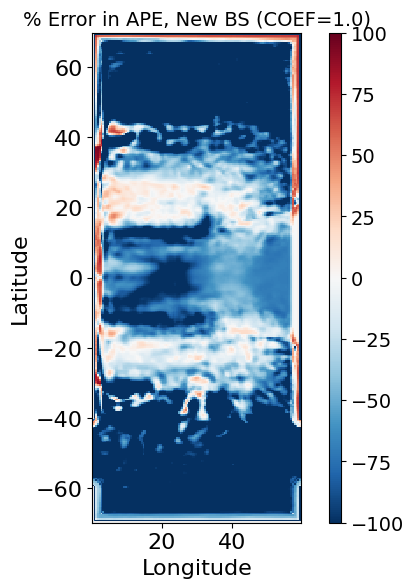

In [46]:
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('% Error in APE, New BS (COEF=1.0)',fontsize=14)

ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=11)



plotted =ax1.pcolor(APE_average.xh,APE_average.yh,100*(APE_average-APE_average_HR)/APE_average,cmap=plt.cm.RdBu_r,vmin=-100,vmax=100)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

In [91]:
np.nansum(APE_average)

1.1109338895746915e+20

In [92]:
np.nansum(APE_average_HR)

8.978396237125929e+19